Compute the loss in optical efficiency when the Feedhorn F/# does not match the optics F/#. This is done as a function of wavelength too, assuming a conical horn whose aperture illumination is specified in Goldsmith.

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import scipy.special as sps
import warnings

In [165]:
# Approximate aperture field distribution of a corrugated conical feedhorn given by
# Goldsmith Eq. 7.36 for y-directed linear polarization.
def corrugated_feed_field(r,a,R,wavelength):
    return sps.j0(2.405*r/a)*np.exp(-1j*np.pi*np.power(r,2)/(wavelength*R))

def jinc(r):
    coords = np.array(r)
    mask = coords==0
    output = 0.5*np.ones(np.shape(coords))
    output[~mask] = sps.j1(coords[~mask])/coords[~mask]
    return output

# Field distribution from diffraction due to an elliptical aperture, given by
# Far-Field Radiation Patterns of Ellipitcal Apertures and Its Annulli by Y.P. Kathuria
# Eq. 4. f is the focal length of the system, 2a, 2b are the major and minor diameter
# of the elliptical aperture.
def elliptical_diffract_field(x,y,f,wavelength,a,b):
    k = 2*np.pi/wavelength
    C = np.exp(1j*k*f)/(1j*wavelength*f)*np.exp(1j*k/(2*f)*(x*x + y*y))
    epsilon = b/a
    K = k*epsilon*a*np.sqrt(x*x + y*y)/f
    return 2*jinc(K) #2*np.pi*epsilon*a*a*C*jinc(K)

In [135]:
jinc([0,0.1,0.2,0.5])

array([0.5       , 0.49937526, 0.49750416, 0.48453692])

In [223]:
# Filepath to the output data stored in a numpy array
filePath = 'TIM_ChromaticResData.npy'
# data is stored in a dictionary with the keys: 'SW' and 'LW', which are dictionaries, 
# each with keys, 'SFNO', 'TFNO', 'CENX', and 'CENY'. Each entry is a numpy array 
# whose rows are fields and columns are wavelegnths
data = np.load(filePath).item()
SWdata = data['SW']
LWdata = data['LW']

# Define parameters

# Feedhorn aperture radius
a = 1

# aperture coordinates
x_ap = np.linspace(-a,a,51)
y_ap = np.linspace(-a,a,51)
X_ap,Y_ap = np.meshgrid(x_ap, y_ap, sparse=False, indexing='xy')
r = np.sqrt(X_ap*X_ap + Y_ap*Y_ap)

# "focal length" (distance between exit pupil and observation plane)
f = 1

# Wavelength bands
SW1 = 240
SW2 = 317
LW1 = 317
LW2 = 420
numWavs = 72
wavs_SW = np.linspace(SW1,SW2,numWavs)
wavs_LW = np.linspace(LW1,LW2,numWavs)

# Feedhorn slant length
R = 8

# F/#
SW_T_coeffs = poly.polyfit(np.linspace(SW1,SW2,len(SWdata['TFNO'][50])), SWdata['TFNO'][50], 2)
SW_S_coeffs = poly.polyfit(np.linspace(SW1,SW2,len(SWdata['TFNO'][50])), SWdata['SFNO'][50], 2)
a_SW = f/(2*poly.polyval(wavs_SW, SW_T_coeffs))
b_SW = f/(2*poly.polyval(wavs_SW, SW_S_coeffs))

LW_T_coeffs = poly.polyfit(np.linspace(LW1,LW2,len(LWdata['TFNO'][50])), LWdata['TFNO'][50], 2)
LW_S_coeffs = poly.polyfit(np.linspace(LW1,LW2,len(LWdata['TFNO'][50])), LWdata['SFNO'][50], 2)
a_LW = f/(2*poly.polyval(wavs_LW, LW_T_coeffs))
b_LW = f/(2*poly.polyval(wavs_LW, LW_S_coeffs))

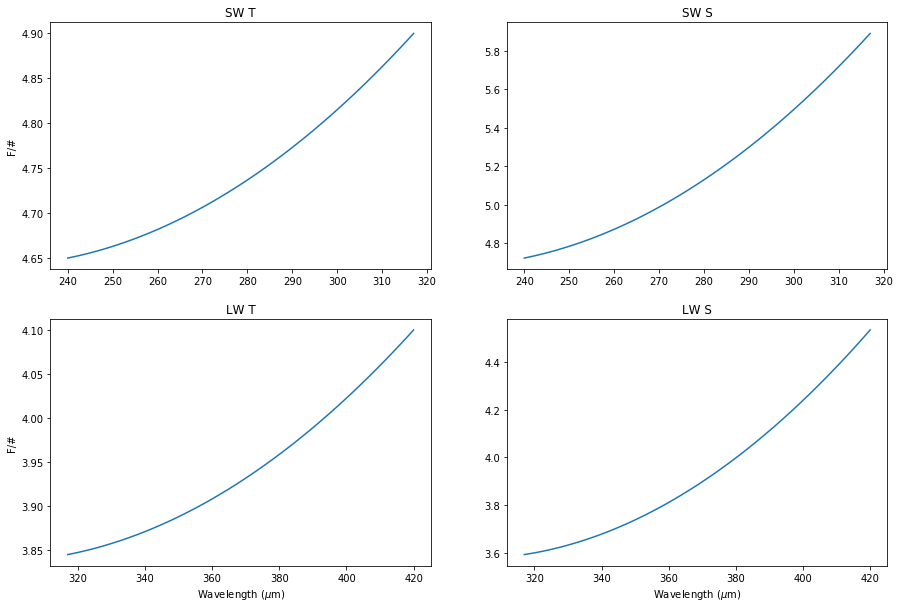

In [234]:
fig, ((ax_SW_T,ax_SW_S), (ax_LW_T,ax_LW_S)) = plt.subplots(2,2,figsize=(15,10))
ax_SW_T.set_title('SW T')
ax_SW_S.set_title('SW S')
ax_LW_T.set_title('LW T')
ax_LW_S.set_title('LW S')

ax_LW_T.set_xlabel(r'Wavelength ($\mu$m)')
ax_LW_S.set_xlabel(r'Wavelength ($\mu$m)')

ax_SW_T.set_ylabel('F/#')
ax_LW_T.set_ylabel('F/#')

ax_SW_T.plot(wavs_SW,poly.polyval(wavs_SW, SW_T_coeffs))
ax_SW_S.plot(wavs_SW,poly.polyval(wavs_SW, SW_S_coeffs))
ax_LW_T.plot(wavs_LW,poly.polyval(wavs_LW, LW_T_coeffs))
ax_LW_S.plot(wavs_LW,poly.polyval(wavs_LW, LW_S_coeffs));

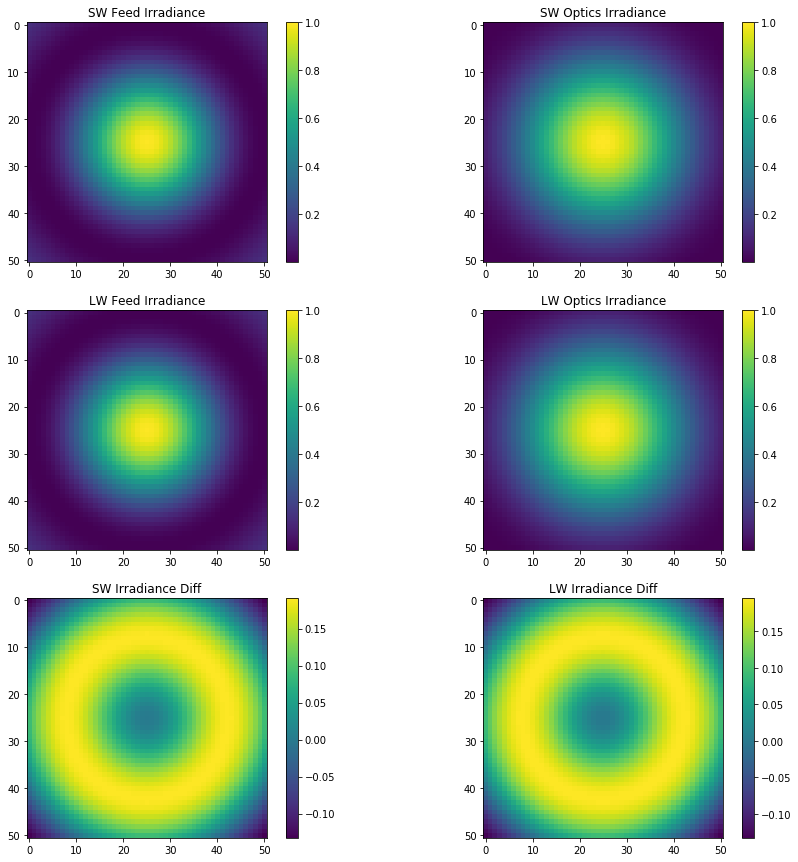

In [235]:
# Multiply fields, compute irradiance, compute power, normalize by power in corrugated feed field.
norm_power_SW = np.empty(numWavs)
norm_power_LW = np.empty(numWavs)
fig, ((ax_SW_feed, ax_SW_optics), (ax_LW_feed, ax_LW_optics), (ax_SW_diff, ax_LW_diff)) = plt.subplots(3,2,figsize=(15,15))
ax_SW_feed.set_title('SW Feed Irradiance')
ax_SW_optics.set_title('SW Optics Irradiance')
ax_SW_diff.set_title('SW Irradiance Diff')
ax_LW_feed.set_title('LW Feed Irradiance')
ax_LW_optics.set_title('LW Optics Irradiance')
ax_LW_diff.set_title('LW Irradiance Diff')

for w in range(numWavs):
    feed_field = corrugated_feed_field(r,a,R,wavs_SW[w]/1000)
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_SW[w]/1000,a_SW[w],b_SW[w])
    power = np.sum(np.sum(feed_field*optics_field*np.conj(feed_field*optics_field)))
    norm_power_SW[w] = power.real/(np.sum(np.sum((optics_field*np.conj(optics_field))))).real
    
    if w == 0:
        im = ax_SW_feed.imshow((feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_SW_feed)
        im = ax_SW_optics.imshow((optics_field*np.conj(optics_field)).real)
        fig.colorbar(im, ax=ax_SW_optics)

        im = ax_SW_diff.imshow((optics_field*np.conj(optics_field) - feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_SW_diff)
    
    # Recompute for the LW module.
    feed_field = corrugated_feed_field(r,a,R,wavs_LW[w]/1000)
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_LW[w]/1000,a_LW[w],b_LW[w])
    power = np.sum(np.sum(feed_field*optics_field*np.conj(feed_field*optics_field)))
    norm_power_LW[w] = power.real/(np.sum(np.sum((optics_field*np.conj(optics_field))))).real
    
    if w == 0:
        im = ax_LW_feed.imshow((feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_LW_feed)
        im = ax_LW_optics.imshow((optics_field*np.conj(optics_field)).real)
        fig.colorbar(im, ax=ax_LW_optics)

        im = ax_LW_diff.imshow((optics_field*np.conj(optics_field) - feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_LW_diff)

In [228]:
print(norm_power_LW[0])
print(norm_power_SW[0])

0.42750749759602746
0.4298690244098218


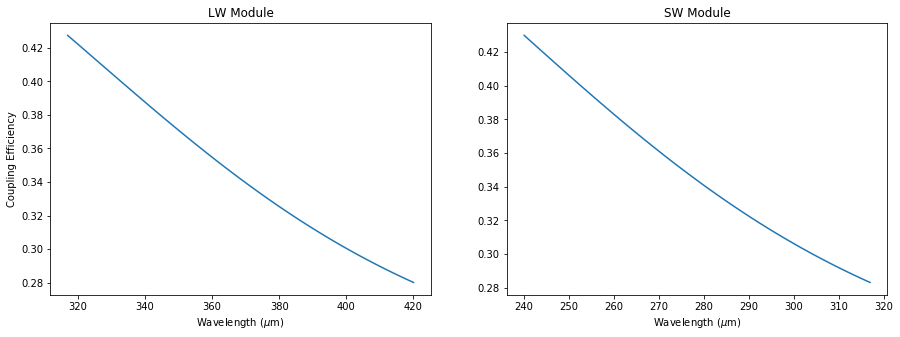

In [229]:
fig, (ax_LW, ax_SW) = plt.subplots(1,2,figsize=(15,5))
ax_LW.plot(wavs_LW, norm_power_LW)
ax_SW.plot(wavs_SW, norm_power_SW)

ax_LW.set_xlabel(r'Wavelength ($\mu$m)')
ax_SW.set_xlabel(r'Wavelength ($\mu$m)')

ax_LW.set_ylabel('Coupling Efficiency')

ax_LW.set_title('LW Module')
ax_SW.set_title('SW Module');